In [1]:
# Author: Başak Kaplan
# Forecasting Inflation for 2024: Time Series Analysis, Predictive Modeling with ARIMA, Direct Forecasting, Recursive Forecasting

In [2]:
# Standard library imports
import itertools
import warnings

# Suppress warnings
warnings.filterwarnings('ignore')

# Third-party imports for data handling
import numpy as np
import pandas as pd

# Third-party imports for statistical modeling
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, kpss
from pmdarima import auto_arima
import ruptures as rpt

# Third-party imports for machine learning
from sklearn.metrics import (
    mean_squared_error,
    mean_absolute_error,
    mean_squared_log_error,
    r2_score,
    f1_score,
    confusion_matrix,
    median_absolute_error,
)
from sklearn.model_selection import train_test_split

# Third-party imports for plotting and visualization
import matplotlib as mpl
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
from matplotlib import pyplot
from pandas.plotting import register_matplotlib_converters
from scipy.stats import pearsonr
from scipy.signal import periodogram
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf, plot_predict
import seaborn as sns
from pylab import rcParams

In [3]:
# Import data
file_path = '/Users/apple/Downloads/prc_hicp_manr__custom_7843973_linear.csv'
data = pd.read_csv(file_path)

data.head()
data.tail()

,DATAFLOW,LAST UPDATE,freq,unit,coicop,geo,TIME_PERIOD,OBS_VALUE,OBS_FLAG
321,ESTAT:PRC_HICP_MANR(1.0),29/09/23 11:00:00,M,RCH_A,CP00,PL,2023-10,6.3,NaN
322,ESTAT:PRC_HICP_MANR(1.0),29/09/23 11:00:00,M,RCH_A,CP00,PL,2023-11,6.3,NaN
323,ESTAT:PRC_HICP_MANR(1.0),29/09/23 11:00:00,M,RCH_A,CP00,PL,2023-12,6.2,NaN
324,ESTAT:PRC_HICP_MANR(1.0),29/09/23 11:00:00,M,RCH_A,CP00,PL,2024-01,4.5,NaN
325,ESTAT:PRC_HICP_MANR(1.0),29/09/23 11:00:00,M,RCH_A,CP00,PL,2024-02,3.7,NaN


In [4]:
# See the data types and non-missing values
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 326 entries, 0 to 325
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   DATAFLOW     326 non-null    object 
 1   LAST UPDATE  326 non-null    object 
 2   freq         326 non-null    object 
 3   unit         326 non-null    object 
 4   coicop       326 non-null    object 
 5   geo          326 non-null    object 
 6   TIME_PERIOD  326 non-null    object 
 7   OBS_VALUE    326 non-null    float64
 8   OBS_FLAG     36 non-null     object 
dtypes: float64(1), object(8)
memory usage: 23.0+ KB


In [5]:
# Cleaning and Formatting
data = data.drop(['DATAFLOW', 'LAST UPDATE', 'freq', 'unit', 'geo', 'OBS_FLAG', 'coicop'], axis=1). \
    rename(columns={'TIME_PERIOD': 'Date', 'OBS_VALUE': 'Rate'})

# Converting the data column into datetime format
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)
data = data.resample('MS').mean()

In [6]:
# Statistics for each column
data.describe()

,Rate
count,326.000000
mean,4.378834
std,4.363395
min,-1.300000
25%,1.400000
50%,3.400000
75%,5.400000
max,17.700000


In [7]:
# Checking for the missing values
data.isna().sum()

Rate    0
dtype: int64

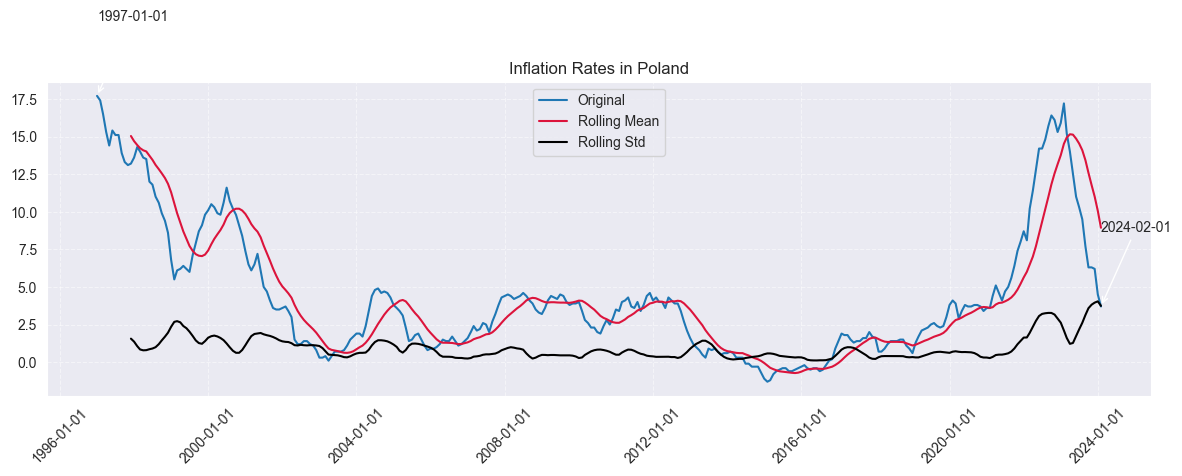

In [8]:
# Visualization
# Rolling mean and standard deviation
mean_rolling = data['Rate'].rolling(window=12).mean()
std_rolling = data['Rate'].rolling(window=12).std()

plt.figure(figsize=(12, 5))
plt.plot(data.index, data['Rate'], label='Original')
plt.plot(mean_rolling.index, mean_rolling, color='crimson', label='Rolling Mean')
plt.plot(std_rolling.index, std_rolling, color='black', label='Rolling Std')
plt.title('Inflation Rates in Poland')
plt.grid(which='major', linestyle='--', alpha=0.5)

# Format the x-axis date labels
date_format = mdates.DateFormatter('%Y-%m-%d')
plt.gca().xaxis.set_major_formatter(date_format)
plt.legend(loc='best')

# Get the first and last dates in the dataset
first_date = data.index[0]
last_date = data.index[-1]

# Annotate the starting and ending points of the rolling mean
plt.annotate(f'{data.index[0].strftime("%Y-%m-%d")}',
             xy=(data.index[0], data.iloc[0]),
             xytext=(data.index[0], data.iloc[0] + 5),
             arrowprops=dict(arrowstyle='->'))
plt.annotate(f'{data.index[-1].strftime("%Y-%m-%d")}',
             xy=(data.index[-1], data.iloc[-1]),
             xytext=(data.index[-1], data.iloc[-1] + 5),
             arrowprops=dict(arrowstyle='->'))
# Display the plot
plt.xticks(rotation=45)
plt.tight_layout()  # Adjust layout to prevent label cutoff
plt.show()

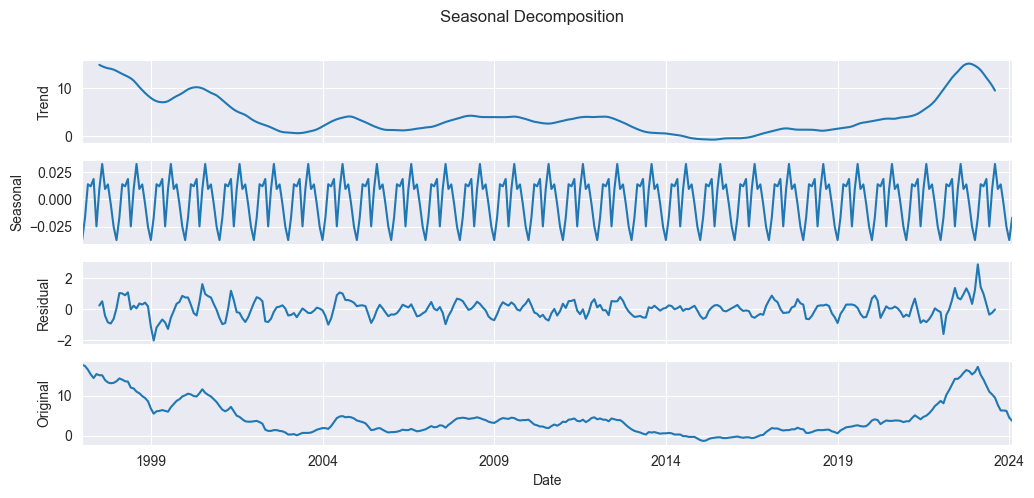

In [9]:
# Seasonal Decomposition
# Set the frequency of the index to monthly start
decomp = seasonal_decompose(data['Rate'], model='Adittive')
fig, axes = plt.subplots(ncols=1, nrows=4, sharex=True, figsize=(12, 5))
fig.suptitle('Seasonal Decomposition')

decomp.trend.plot(ax=axes[0], legend=False)
axes[0].set_ylabel('Trend')
decomp.seasonal.plot(ax=axes[1], legend=False)
axes[1].set_ylabel('Seasonal')
decomp.resid.plot(ax=axes[2], legend=False)
axes[2].set_ylabel('Residual')
decomp.observed.plot(ax=axes[3], legend=False)
axes[3].set_ylabel('Original')
plt.show()

In [10]:
# Stationary Check
# ADF Test
def adf_test(series):
    result = adfuller(series, regression='c', autolag='AIC')
    print('====Augmented Dickey-Fuller Test Results====\n')
    print(f'ADF Statistic: {result[0]:.6f}')
    print(f'p-value: {result[1]:.6f}')
    print(f'# Lags used: {result[2]}')
    print(f'Number of observations: {result[3]}')
    print('Critical values:')
    for key, value in result[4].items():
        print(f'\t{key}: {value:.6f}')

    # Simplifying the logic for rejecting the null hypothesis
    if result[1] < 0.05:
        print('\nReject the null hypothesis. Data has no unit root and is stationary.')
    else:
        print('\nCannot reject the null hypothesis. Data may have a unit root and be non-stationary.')

adf_test(data['Rate'])

====Augmented Dickey-Fuller Test Results====

ADF Statistic: -3.405591
p-value: 0.010770
# Lags used: 13
Number of observations: 312
Critical values:
	1%: -3.451484
	5%: -2.870849
	10%: -2.571730

Reject the null hypothesis. Data has no unit root and is stationary.


In [11]:
# KPSS Test
# Perform the KPSS test on the 'Rate' column
result = kpss(data['Rate'])

print('======= Kwiatkowski-Phillips-Schmidt-Shin (KPSS) Test Results =======\n')
print("KPSS Test Statistic:", result[0])
print("p-value:", result[1])
print("# Lags used: ", result[2])
print("Critical Values:")
for key, value in result[3].items():
    print(f"\t{key}: {value}")

# Interpretation of the KPSS test results
critical_value = result[3]['5%']
if result[0] > critical_value:
    print('\nStrong evidence against the null hypothesis, we reject the null hypothesis. Data is non-stationary.')
else:
    print('\nWeak evidence against rejecting the null hypothesis. Data has no unit root and is stationary.')

======= Kwiatkowski-Phillips-Schmidt-Shin (KPSS) Test Results =======

KPSS Test Statistic: 0.5278370585150787
p-value: 0.035397058893000294
# Lags used:  11
Critical Values:
	10%: 0.347
	5%: 0.463
	2.5%: 0.574
	1%: 0.739

Strong evidence against the null hypothesis, we reject the null hypothesis. Data is non-stationary.


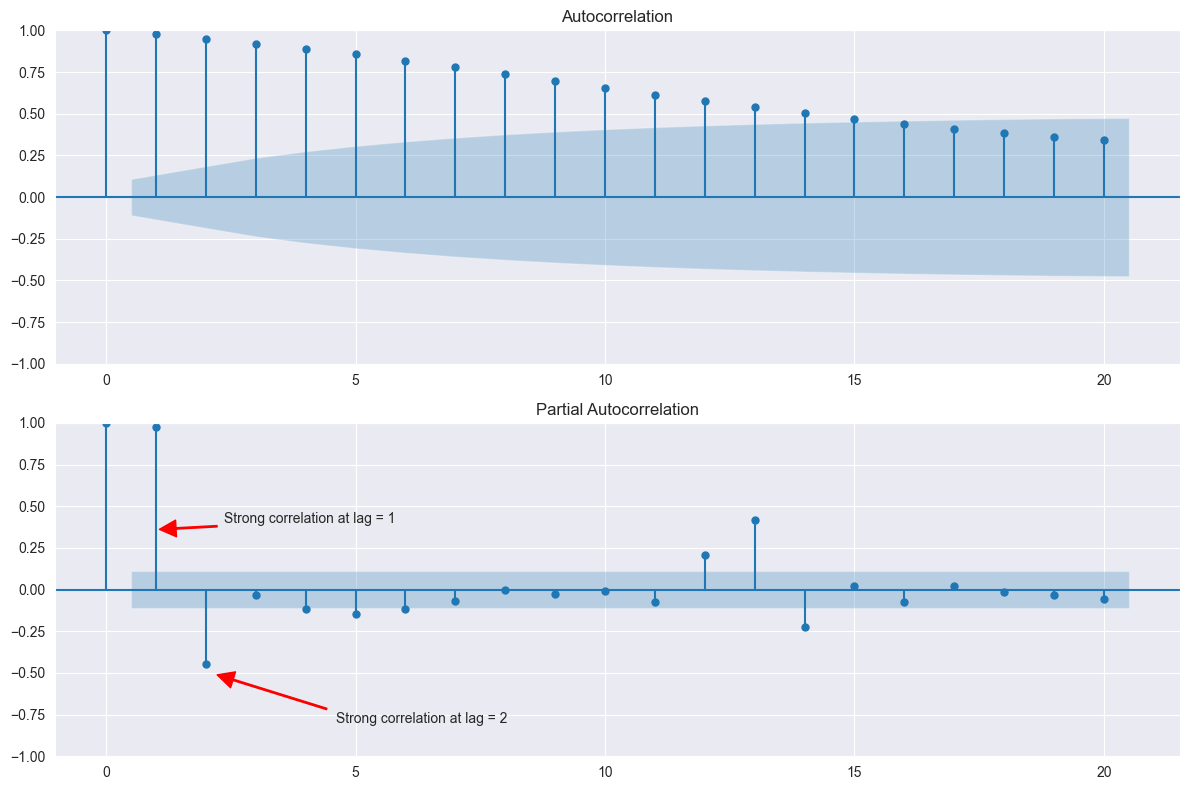

In [12]:
# ACF and PACF
f, ax = plt.subplots(nrows=2, ncols=1, figsize=(12, 8))
plot_acf(data['Rate'], lags=20, ax=ax[0])
plot_pacf(data['Rate'], lags=20, ax=ax[1], method='ols')

ax[1].annotate('Strong correlation at lag = 1', xy=(1, 0.36), xycoords='data',
               xytext=(0.15, 0.7), textcoords='axes fraction',
               arrowprops=dict(color='red', shrink=0.05, width=1))

ax[1].annotate('Strong correlation at lag = 2', xy=(2.1, -0.5), xycoords='data',
               xytext=(0.25, 0.1), textcoords='axes fraction',
               arrowprops=dict(color='red', shrink=0.05, width=1))
plt.tight_layout()
plt.show()

Frequency	Power
0.0000		0.0000
0.0003		31741.7432
0.0005		26337.8220
0.0008		941.8961
0.0010		519.4558
0.0013		1044.3454
0.0015		1172.4904
0.0018		919.5364
0.0020		1066.2940
0.0023		813.5342
Peak Frequency: 0.0003
Peak Power: 31741.7432


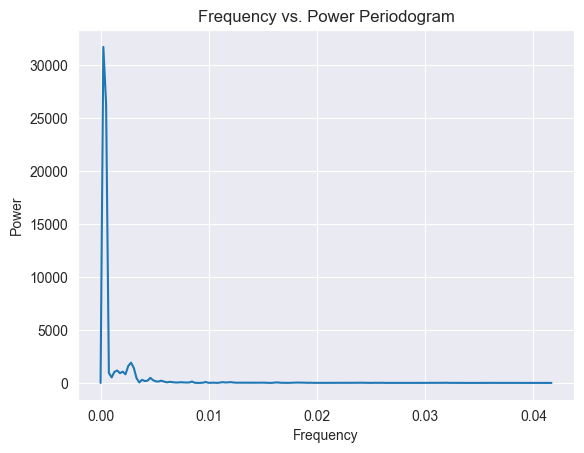

In [13]:
# Cyclic Behavior Detection: Frequency vs. periodogram
fs = 1 / 12  # The sampling frequency. For monthly data, it would be 1 sample per month.
# Compute the periodogram
frequencies, power = periodogram(data['Rate'], fs=fs)

# Print the first few values
print("Frequency\tPower")
for freq, pwr in zip(frequencies[:10], power[:10]):  # Adjust the slice as needed
    print(f"{freq:.4f}\t\t{pwr:.4f}")

# Find the index of the maximum power
max_power_index = np.argmax(power)
max_frequency = frequencies[max_power_index]
max_power = power[max_power_index]

print(f"Peak Frequency: {max_frequency:.4f}")
print(f"Peak Power: {max_power:.4f}")

# Plot the frequency vs. power periodogram for cyclic behavior
plt.plot(frequencies, power)
plt.xlabel('Frequency')
plt.ylabel('Power')
plt.title('Frequency vs. Power Periodogram')
plt.show()

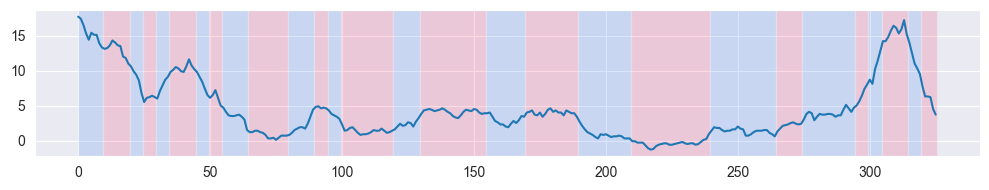

Change points detected at indices: [10, 20, 25, 30, 35, 45, 50, 55, 65, 80, 90, 95, 100, 120, 130, 155, 170, 190, 210, 240, 265, 275, 295, 300, 305, 315, 320, 326]


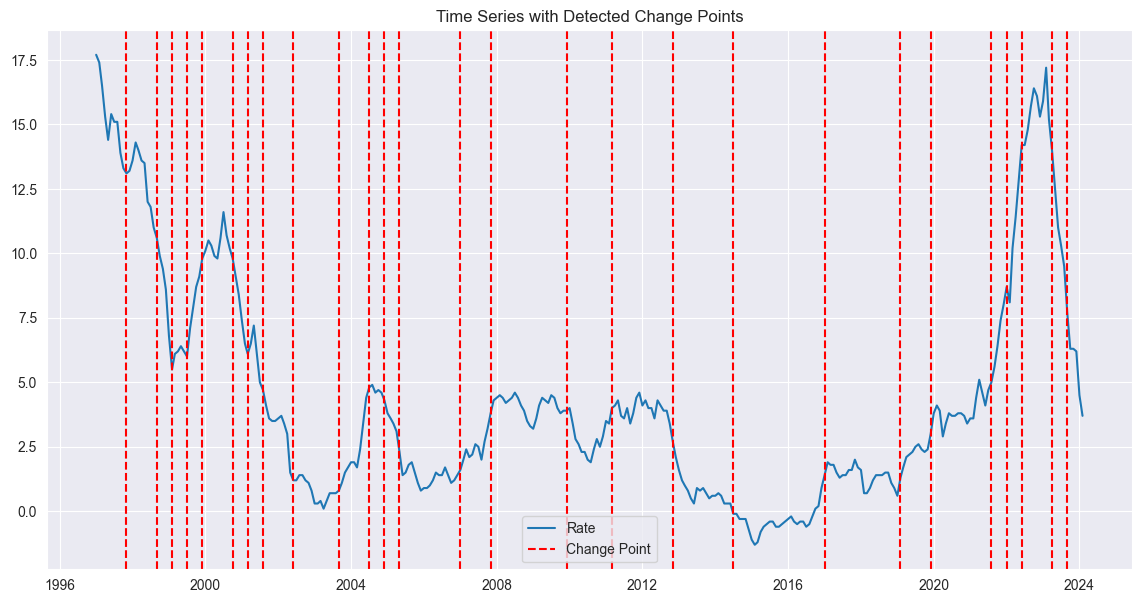

Dates of detected structural breaks:
DatetimeIndex(['1997-11-01', '1998-09-01', '1999-02-01', '1999-07-01',
               '1999-12-01', '2000-10-01', '2001-03-01', '2001-08-01',
               '2002-06-01', '2003-09-01', '2004-07-01', '2004-12-01',
               '2005-05-01', '2007-01-01', '2007-11-01', '2009-12-01',
               '2011-03-01', '2012-11-01', '2014-07-01', '2017-01-01',
               '2019-02-01', '2019-12-01', '2021-08-01', '2022-01-01',
               '2022-06-01', '2023-04-01', '2023-09-01'],
              dtype='datetime64[ns]', name='Date', freq=None)


In [14]:
# Bai-Perron test for Structural Breakpoint Test
# Convert index to integer for analysis
data['Time'] = range(len(data))

# Detection
algo = rpt.Pelt(model="l1").fit(data['Rate'].values)
result = algo.predict(pen=3)

# Display results
rpt.display(data['Rate'].values, result)
plt.show()

# Print change points
print("Change points detected at indices:", result)

change_points = [10, 20, 25, 30, 35, 45, 50, 55, 65, 80, 90, 95, 100, 120, 130, 155, 170, 190, 210, 240, 265, 275, 295,
                 300, 305, 315, 320, 326]

# Filter out any indices that are out of bounds for the DataFrame's size
change_points = [cp for cp in change_points if cp < len(data)]

# Plot the time series
plt.figure(figsize=(14, 7))
plt.plot(data.index, data['Rate'], label='Rate')

# Mark each change point with a vertical line
for cp in change_points:
    plt.axvline(x=data.index[cp], color='r', linestyle='--', label='Change Point' if cp == change_points[0] else "")

# Adding legend only once for Change Point
plt.legend()
plt.title('Time Series with Detected Change Points')
plt.show()

# Retrieve the dates corresponding to these indices
break_dates = data.index[change_points]
print("Dates of detected structural breaks:")
print(break_dates)

data.drop(['Time'], axis=1, inplace=True)

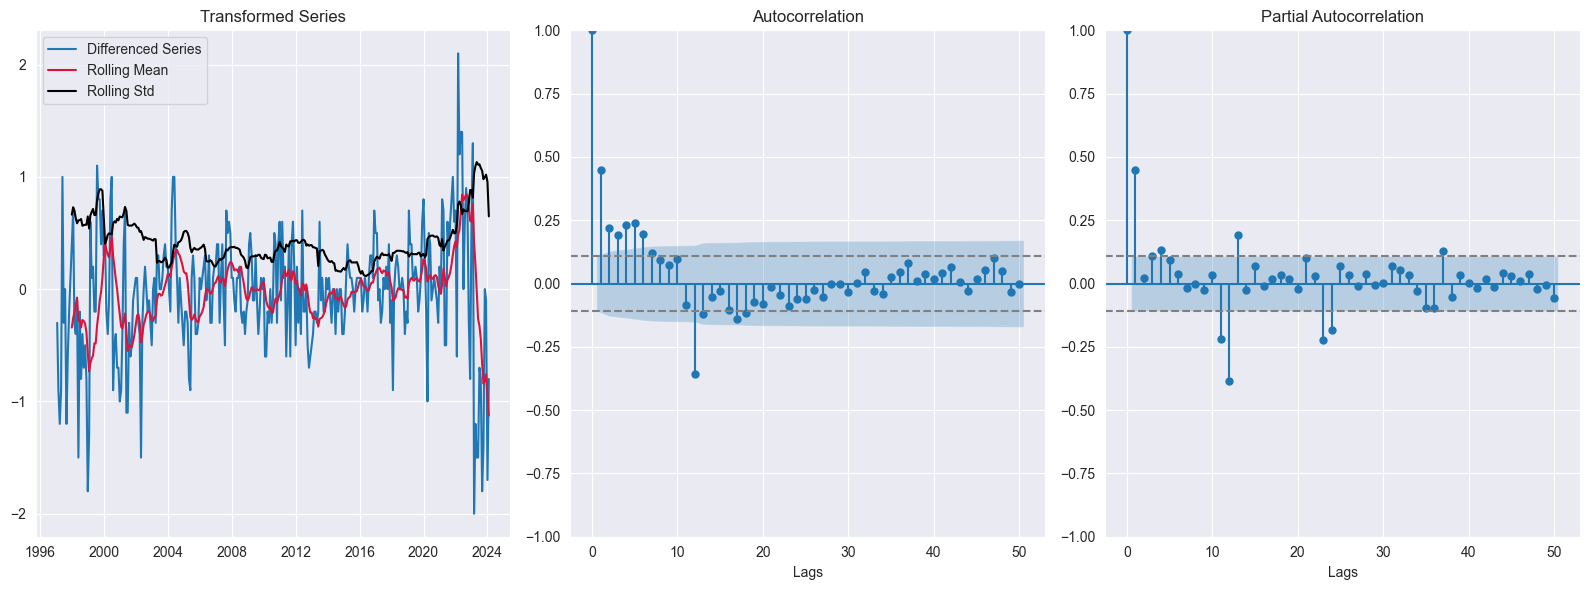

ADF Statistic: -5.3412815506681355
p-value: 4.494441744048794e-06
Critical Value (1%): -3.4514843502727306
Critical Value (5%): -2.8708485956333556
Critical Value (10%): -2.571729625657462
Series is stationary.
KPSS Test Statistic: 0.22909819345688207
p-value: 0.1
Critical Value (10%): 0.347
Critical Value (5%): 0.463
Critical Value (2.5%): 0.574
Critical Value (1%): 0.739
No evidence against the null hypothesis; the series is stationary.


/var/folders/vb/kcvn0bhj6yl2ftbtxj09bfjc0000gn/T/ipykernel_2255/3196833728.py:44: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series.dropna(), nlags='auto')  # Using 'auto' to automatically select the number of lags


In [15]:
# Differencing
def transformation(series):
    register_matplotlib_converters()

    # Plot the transformed (differenced) series
    fig = plt.figure(figsize=(16, 6))
    ax1 = fig.add_subplot(1, 3, 1)
    ax1.set_title('Transformed Series')
    ax1.plot(series, label='Differenced Series')
    ax1.plot(series.rolling(window=12).mean(), color='crimson', label='Rolling Mean')
    ax1.plot(series.rolling(window=12).std(), color='black', label='Rolling Std')
    ax1.legend()

    # Autocorrelation Plot
    ax2 = fig.add_subplot(1, 3, 2)
    plot_acf(series.dropna(), ax=ax2, lags=50, title='Autocorrelation')
    # Plot 95% confidence intervals
    ax2.axhline(y=-1.96 / np.sqrt(len(series)), linestyle='--', color='gray')
    ax2.axhline(y=1.96 / np.sqrt(len(series)), linestyle='--', color='gray')
    ax2.set_xlabel('Lags')

    # Partial Autocorrelation Plot
    ax3 = fig.add_subplot(1, 3, 3)
    plot_pacf(series.dropna(), ax=ax3, lags=50, title="Partial Autocorrelation")
    # Plot 95% confidence intervals
    ax3.axhline(y=-1.96 / np.sqrt(len(series)), linestyle='--', color='gray')
    ax3.axhline(y=1.96 / np.sqrt(len(series)), linestyle='--', color='gray')
    ax3.set_xlabel('Lags')
    plt.tight_layout()
    plt.show()

    # ADF Test to check Stationarity
    result = adfuller(series.dropna(), autolag='AIC')
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {result[1]}')
    for key, value in result[4].items():
        print(f'Critical Value ({key}): {value}')
    if result[1] < 0.05:
        print('Series is stationary.')
    else:
        print('Series is not stationary.')

    # KPSS Test
    result = kpss(series.dropna(), nlags='auto')  # Using 'auto' to automatically select the number of lags
    print("KPSS Test Statistic:", result[0])
    print("p-value:", result[1])
    for key, value in result[3].items():
        print(f'Critical Value ({key}): {value}')
    # Correct interpretation of the KPSS test results
    if result[1] < 0.05:
        print('Evidence suggests the series is not stationary.')
    else:
        print('No evidence against the null hypothesis; the series is stationary.')

transformation(data.diff())

In [16]:

# Finding p d q values
train_data = data[1:len(data) - 12]
test_data = data[len(data) - 12:]

# Define the range of p, d, and q values for ARIMA parameters
# Since 'd' is already given as 2, we only define ranges for 'p' and 'q'
p = range(0, 3)
q = range(0, 8)
d = 1

# Generate all possible combinations of p, d, and q (with d fixed at 2)
pdq = list(itertools.product(p, [d], q))

# Initialize variables to store the best parameters and minimum AIC
best_aic = float('inf')
best_params = None

# Loop through all combinations of parameters
for param in pdq:
    try:
        mod = sm.tsa.ARIMA(data['Rate'],
                           order=param,
                           enforce_stationarity=False,
                           enforce_invertibility=False)
        results = mod.fit()

        # Check if the current AIC is the best so far
        if results.aic < best_aic:
            best_aic = results.aic
            best_params = param

        print(f'ARIMA{param} - AIC:{results.aic}')
    except Exception as e:
        print(f'Error for ARIMA{param}: {str(e)}')
        continue

# Print the best AIC and corresponding parameters
print(f'Best AIC: {best_aic}')
print(f'Best Parameters: {best_params}')

ARIMA(0, 1, 0) - AIC:531.0181066160212
ARIMA(0, 1, 1) - AIC:467.7090397633113
ARIMA(0, 1, 2) - AIC:458.62954566444205
ARIMA(0, 1, 3) - AIC:458.18622555012496
ARIMA(0, 1, 4) - AIC:448.57403324164335
ARIMA(0, 1, 5) - AIC:442.04113651756796
ARIMA(0, 1, 6) - AIC:439.3816296441945
ARIMA(0, 1, 7) - AIC:420.07567110090145
ARIMA(1, 1, 0) - AIC:458.32428495062976
ARIMA(1, 1, 1) - AIC:456.55412347058603
ARIMA(1, 1, 2) - AIC:448.5337182224554
ARIMA(1, 1, 3) - AIC:450.22154676359264
ARIMA(1, 1, 4) - AIC:436.24913244984793
ARIMA(1, 1, 5) - AIC:434.97866383308786
ARIMA(1, 1, 6) - AIC:420.51830958008793
ARIMA(1, 1, 7) - AIC:416.56148762315433
ARIMA(2, 1, 0) - AIC:457.1446790012617
ARIMA(2, 1, 1) - AIC:452.4457788328291
ARIMA(2, 1, 2) - AIC:449.8747661618054
ARIMA(2, 1, 3) - AIC:434.6568534333795
ARIMA(2, 1, 4) - AIC:428.038079758083
ARIMA(2, 1, 5) - AIC:441.1948255971981
ARIMA(2, 1, 6) - AIC:416.46968407473094
ARIMA(2, 1, 7) - AIC:400.8680963413577
Best AIC: 400.8680963413577
Best Parameters: (2, 1, 

/Users/apple/.virtualenvs/pythonProject3/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [17]:
# Best BIC
# Only define ranges for 'p' and 'q' based on ACF and PACF
p = range(0, 3)
q = range(0, 8)
d = 1  # d is already determined to be 1

# Generate all possible combinations of p, d, and q (with d fixed at d=1)
pdq = list(itertools.product(p, [d], q))

# Initialize variables to store the best parameters and minimum BIC
best_bic = float('inf')
best_params = None

# Loop through all combinations of parameters
for param in pdq:
    try:
        mod = sm.tsa.ARIMA(train_data['Rate'],
                           order=param,
                           enforce_stationarity=False,
                           enforce_invertibility=False)
        results = mod.fit()

        # Check if the current BIC is the best so far
        if results.bic < best_bic:
            best_bic = results.bic
            best_params = param

        print(f'ARIMA{param} - BIC:{results.bic}')
    except Exception as e:
        print(f'Error for ARIMA{param}: {str(e)}')
        continue

# Print the best BIC and corresponding parameters
print(f'Best BIC: {best_bic}')
print(f'Best Parameters: {best_params}')

ARIMA(0, 1, 0) - BIC:452.01940063474245
ARIMA(0, 1, 1) - BIC:399.8900530446302
ARIMA(0, 1, 2) - BIC:396.21676004898444
ARIMA(0, 1, 3) - BIC:391.9599372749567
ARIMA(0, 1, 4) - BIC:394.7633896934356
ARIMA(0, 1, 5) - BIC:396.81432316962184
ARIMA(0, 1, 6) - BIC:394.1083711359167
ARIMA(0, 1, 7) - BIC:389.64516864745246
ARIMA(1, 1, 0) - BIC:394.1007676891675
ARIMA(1, 1, 1) - BIC:396.193274048466
ARIMA(1, 1, 2) - BIC:398.8327500393139
ARIMA(1, 1, 3) - BIC:389.25810687981357
ARIMA(1, 1, 4) - BIC:394.49768820957837
ARIMA(1, 1, 5) - BIC:393.0696636139021
ARIMA(1, 1, 6) - BIC:387.5645388189707
ARIMA(1, 1, 7) - BIC:390.7553972686492
ARIMA(2, 1, 0) - BIC:396.210803507641
ARIMA(2, 1, 1) - BIC:400.3966542708563
ARIMA(2, 1, 2) - BIC:404.2493873267874
ARIMA(2, 1, 3) - BIC:391.4597661372945
ARIMA(2, 1, 4) - BIC:386.3461915147523
ARIMA(2, 1, 5) - BIC:385.9622137479086
ARIMA(2, 1, 6) - BIC:387.70969413805375
ARIMA(2, 1, 7) - BIC:387.01619198816877
Best BIC: 385.9622137479086
Best Parameters: (2, 1, 5)


In [18]:
# ARIMA
model = ARIMA(data['Rate'], order=(2, 1, 5))
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                   Rate   No. Observations:                  326
Model:                 ARIMA(2, 1, 5)   Log Likelihood                -216.807
Date:                Tue, 16 Apr 2024   AIC                            449.613
Time:                        00:19:07   BIC                            479.884
Sample:                    01-01-1997   HQIC                           461.694
                         - 02-01-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0937      0.063     -1.477      0.140      -0.218       0.031
ar.L2          0.7802      0.057     13.590      0.000       0.668       0.893
ma.L1          0.4977      0.118      4.206      0.0

/Users/apple/.virtualenvs/pythonProject3/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [19]:
# Forecasting for 5 months into the future
prediction = model_fit.forecast(steps=5)
for month in range(3, 8):
    year = 2024
    predicted_inflation = prediction[(prediction.index.year == year) & (prediction.index.month == month)].values[0]
    print(
        f"Poland's predicted inflation rate for {pd.Timestamp(year, month, 1).strftime('%B %Y')} is: {predicted_inflation}%")

Poland's predicted inflation rate for March 2024 is: 3.2893847854810847%
Poland's predicted inflation rate for April 2024 is: 2.978240972384015%
Poland's predicted inflation rate for May 2024 is: 2.5418032548725025%
Poland's predicted inflation rate for June 2024 is: 2.1705337015658293%
Poland's predicted inflation rate for July 2024 is: 1.8943653384655899%


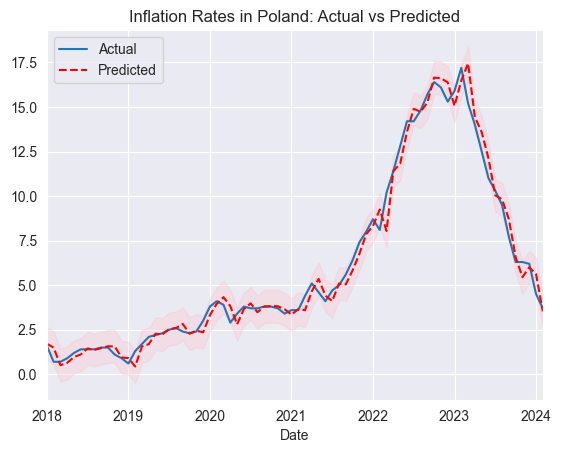

In [20]:
# Generate predictions and confidence intervals
pred = model_fit.get_prediction(start=pd.to_datetime('2018-01-01'), dynamic=False)
pred_ci = pred.conf_int()
# Plot the actual data and predictions
fig, ax = plt.subplots()
data.loc['2018':].plot(ax=ax)  # Actual data
pred.predicted_mean.plot(ax=ax, style='r--')  # Predicted mean
ax.fill_between(pred_ci.index, pred_ci.iloc[:, 0], pred_ci.iloc[:, 1], color='pink', alpha=0.3)  # Confidence interval
ax.set_title('Inflation Rates in Poland: Actual vs Predicted')
ax.legend(['Actual', 'Predicted'])
plt.show()

<Axes: xlabel='Date'>

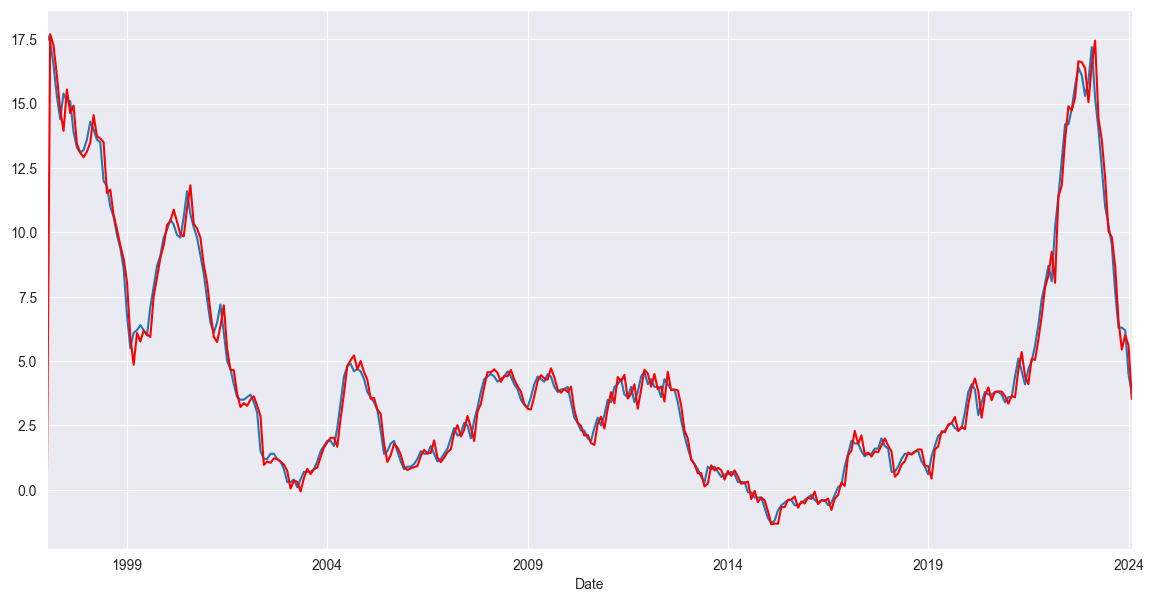

In [21]:
# Plot the actual data, fitted values, and predictions
fig, ax = plt.subplots(figsize=(14, 7))
data['Rate'].plot(ax=ax, label='Actual')
model_fit.fittedvalues.plot(ax=ax, color='red', label='Fitted')

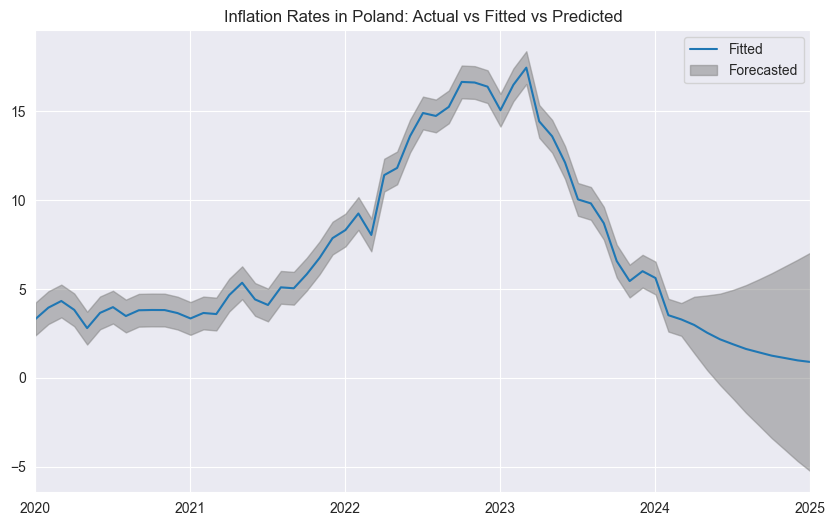

In [22]:
# Predictions
# Plot predictions
fig, ax = plt.subplots(figsize=(10, 6))
plot_predict(model_fit, start='2020-01-01', end='2025-01-01', ax=ax, plot_insample=True)
ax.set_title('Inflation Rates in Poland: Actual vs Fitted vs Predicted')
ax.legend(['Fitted', 'Forecasted'])
plt.show()

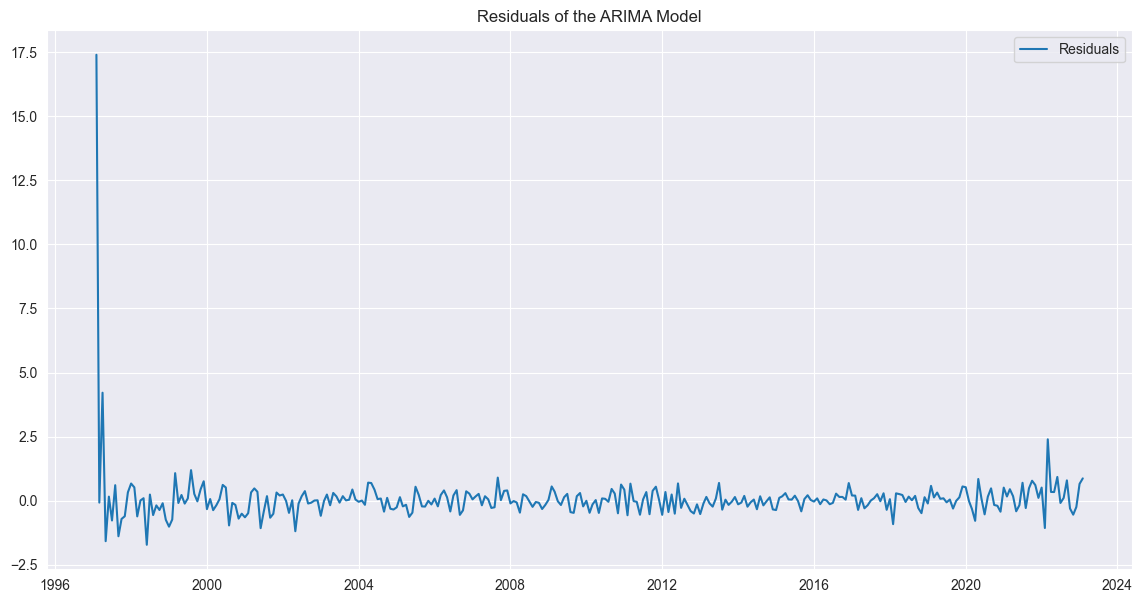

count    313.000000
mean       0.064596
std        1.101201
min       -1.722200
25%       -0.232990
50%        0.019714
75%        0.236897
max       17.400000
dtype: float64


In [23]:
# Calculate Residuals
residuals = data['Rate'] - results.fittedvalues

# Plot residuals
plt.figure(figsize=(14, 7))
plt.plot(residuals.index, residuals, label='Residuals')
plt.title('Residuals of the ARIMA Model')
plt.legend(loc='best')
plt.show()
print(residuals.describe())

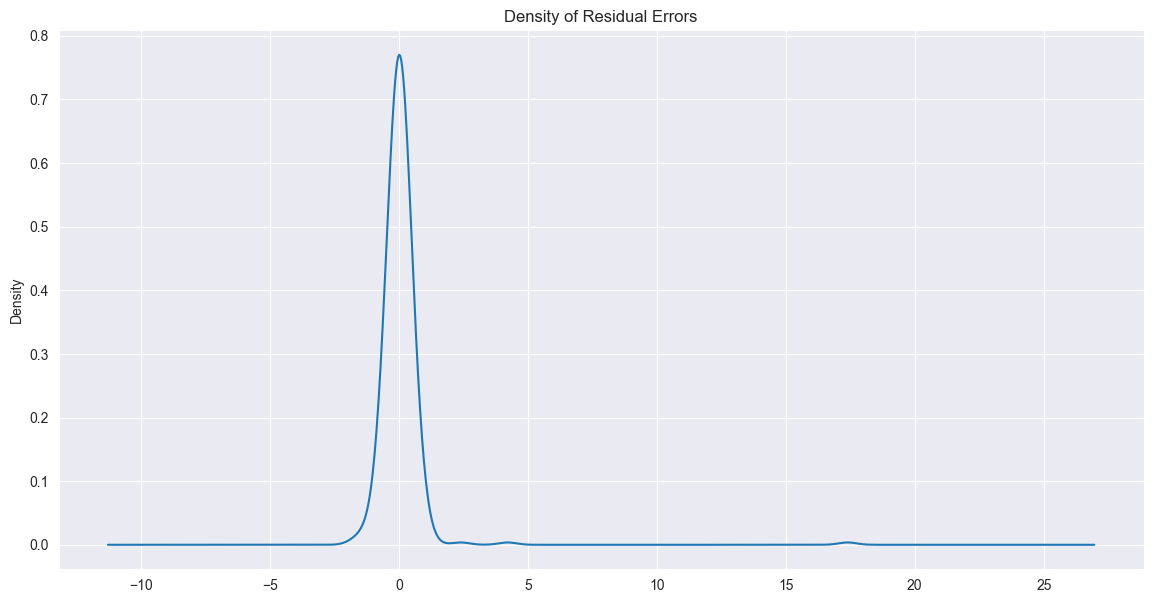

In [24]:
# Density of Residual Errors
fig, ax = plt.subplots(figsize=(14, 7))
residuals.plot(kind='kde', ax=ax, title="Density of Residual Errors")
plt.show()

In [25]:
# Find the date of the maximum residuals
residuals = data['Rate'] - results.fittedvalues
max_residual_date = residuals.nlargest(1).idxmin()
print(f"The date of the maximum residual is: {max_residual_date}")

# Find the date of the second maximum residual
second_max_residual_date = residuals.nlargest(2).idxmin()
print(f"The date of the second maximum residual is: {second_max_residual_date}")

The date of the maximum residual is: 1997-02-01 00:00:00
The date of the second maximum residual is: 1997-04-01 00:00:00


In [26]:
# Another Approach: Recursive Forecasting
def recursive_forecast(data, start_date, end_date, forecast_horizon, order):
    """
    Performs recursive forecasting and calculates forecast errors.

    Parameters:
    - data: pd.Series, time series data with datetime index.
    - start_date: str, initial model estimation period end.
    - end_date: str, last date to include in forecasting.
    - forecast_horizon: int, number of steps ahead to forecast.
    - order: tuple, ARIMA model order (p, d, q).

    Returns:
    - dict: Forecast errors for each horizon (ME, MAE, RMSE).
    """
    forecast_errors = {i: [] for i in range(1, forecast_horizon + 1)}

    for end_date in pd.date_range(start=pd.Timestamp(start_date), end=pd.Timestamp(end_date), freq='M'):
        train_data = data[:end_date]
        model = ARIMA(train_data, order=order)
        model_fit = model.fit()

        forecast = model_fit.forecast(steps=forecast_horizon)
        actual = data[end_date + pd.offsets.MonthBegin(1):].head(forecast_horizon)

        for i, (pred, act) in enumerate(zip(forecast, actual), start=1):
            forecast_errors[i].append(act - pred)

    # Calculate error metrics
    error_metrics = {}
    for horizon in range(1, forecast_horizon + 1):
        errors = forecast_errors[horizon]
        me = np.mean(errors)
        mae = np.mean(np.abs(errors))
        rmse = np.sqrt(np.mean(np.square(errors)))
        error_metrics[horizon] = {'ME': me, 'MAE': mae, 'RMSE': rmse}

    return error_metrics

# Example usage:
time_series_data = data['Rate']
start_date = '2018-01-01'
end_date = '2024-02-01'
forecast_horizon = 4
order = (2, 1, 5)

In [27]:
# Forecast Evaluation
errors = recursive_forecast(time_series_data, start_date, end_date, forecast_horizon, order)
for horizon, metrics in errors.items():
    print(f"Forecast Horizon {horizon} months:")
    print(f"ME: {metrics['ME']:.4f}, MAE: {metrics['MAE']:.4f}, RMSE: {metrics['RMSE']:.4f}")

/Users/apple/.virtualenvs/pythonProject3/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/apple/.virtualenvs/pythonProject3/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/apple/.virtualenvs/pythonProject3/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/apple/.virtualenvs/pythonProject3/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed t

Forecast Horizon 1 months:
ME: 0.0093, MAE: 0.4676, RMSE: 0.6553
Forecast Horizon 2 months:
ME: 0.0402, MAE: 0.8334, RMSE: 1.1043
Forecast Horizon 3 months:
ME: 0.1109, MAE: 1.0689, RMSE: 1.4231
Forecast Horizon 4 months:
ME: 0.1867, MAE: 1.2478, RMSE: 1.7572
